In [1]:
import math
import pickle
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm.autonotebook import tqdm
from tqdm import tqdm_notebook

%matplotlib inline

/Users/qingemeng/Documents/dev/cs498aml/env/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Load data

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data(data_dir):
    data = np.empty((0, 3072))
    labels = []
    for i in range(6) :
        if(i == 0):
            file = f'{data_dir}/test_batch'
        else:
            file = f'{data_dir}/data_batch_{i}'
        batch = unpickle(file)
        data = np.vstack((data, batch[b'data']))
        labels = labels + batch[b'labels']
    return data, labels

In [3]:
dict_test = unpickle('data/hw4/cifar-10-batches-py/test_batch')
X, Y = load_data('data/hw4/cifar-10-batches-py')

In [4]:
X.shape, len(Y)

((60000, 3072), 60000)

In [5]:
df = pd.DataFrame(np.hstack((X, np.array(Y).reshape(60000, 1))))

In [6]:
df.rename(columns={3072: 'label'}, inplace=True)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,158.0,159.0,165.0,166.0,160.0,156.0,162.0,159.0,158.0,159.0,...,123.0,145.0,167.0,182.0,175.0,145.0,124.0,129.0,110.0,3.0
1,235.0,231.0,232.0,232.0,232.0,232.0,232.0,232.0,232.0,232.0,...,117.0,123.0,133.0,141.0,153.0,163.0,178.0,191.0,199.0,8.0
2,158.0,158.0,139.0,132.0,166.0,182.0,187.0,193.0,199.0,205.0,...,46.0,44.0,44.0,43.0,52.0,37.0,8.0,3.0,7.0,8.0
3,155.0,167.0,176.0,190.0,177.0,166.0,168.0,166.0,170.0,179.0,...,55.0,70.0,103.0,105.0,72.0,53.0,50.0,52.0,50.0,0.0
4,65.0,70.0,48.0,30.0,23.0,40.0,44.0,45.0,45.0,40.0,...,127.0,156.0,139.0,131.0,130.0,147.0,136.0,146.0,117.0,6.0


## Get mean image

In [8]:
def get_mean_image(rows):
    return rows.mean(axis=0)

In [9]:
mean_images = df.groupby(['label']).apply(get_mean_image)

In [10]:
mean_images.shape

(10, 3073)

In [11]:
def plot_mean_imgs(means):
    for mean in np.array(means):
        fig, ax = plt.subplots()
        R = mean[0:1024].reshape(32,32)/255.0
        G = mean[1024:2048].reshape(32,32)/255.0
        B = mean[2048:3072].reshape(32,32)/255.0
        lable = mean[-1]
    
        img = np.dstack((R,G,B))
        ax.set_title(f'label: {lable}')

        ax.imshow(img)

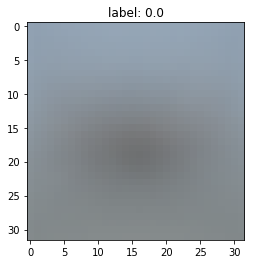

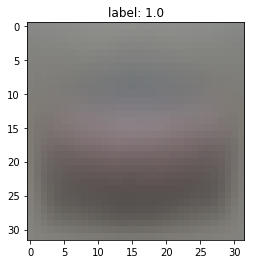

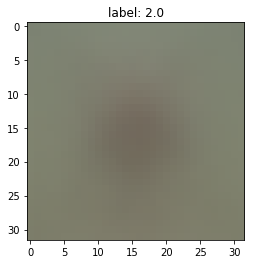

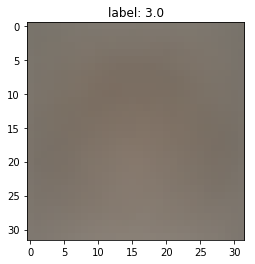

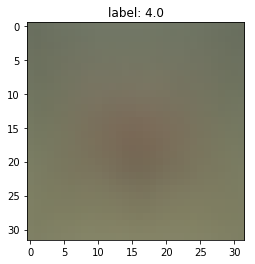

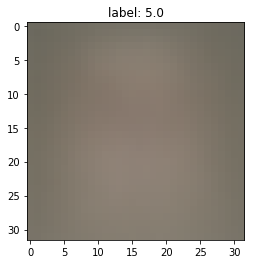

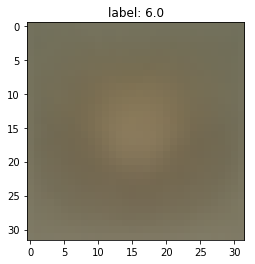

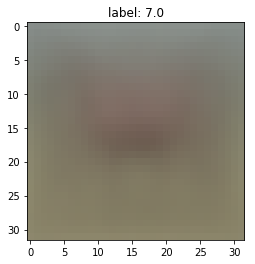

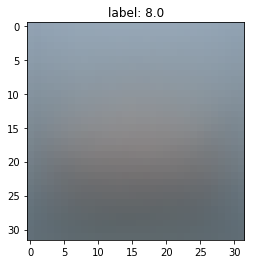

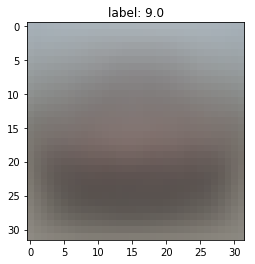

In [12]:
plot_mean_imgs(mean_images)

## Reconstruct low-dimension images

In [13]:
def reconstruct_low_dimentsion_images(origin, target, n_components=20):
        pca = PCA(n_components=n_components).fit(origin)
        components = pca.transform(target)
        return pca.inverse_transform(components)
    
reconstructed = reconstruct_low_dimentsion_images(X, X)

## Plot squared euclidean distance

In [14]:
def squared_euclidean_distance(img1, img2):
    return math.pow((distance.euclidean(img1, img2)), 2)

In [15]:
def get_dists(A, B):
    distances = []
    for i, img in enumerate(A):
        dist = squared_euclidean_distance(img, B[i])
        distances.append(dist)
    return distances

In [16]:
distances = get_dists(X, reconstructed)

In [17]:
len(distances)

60000

In [18]:
def plot_distance(distances, labels):
    data = np.vstack((distances, labels))
    df = pd.DataFrame(data.T, columns=['dist', 'label'])
    g = df.groupby(['label'])
    mean_dists = g.mean()
    fig, ax = plt.subplots()
    ax.set_title('squared_euclidean_distance')
    plt.bar(g.groups.keys(), mean_dists.dist, tick_label=list(g.groups.keys()))

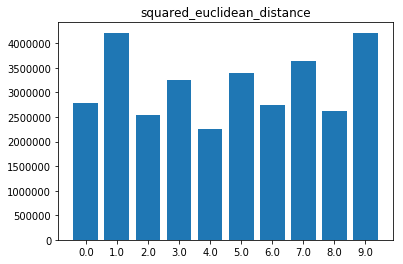

In [19]:
plot_distance(distances, Y)


## Part B

## Euclidean distance between the mean images of class

In [20]:
def get_mean_image_sqr_distances_matrix(mean_images):
    matrix = np.zeros((10, 10))
    for i, mean1 in enumerate(mean_images):
        for j, mean2 in enumerate(mean_images):
            matrix[i][j] = squared_euclidean_distance(mean1, mean2)
    return matrix

In [21]:
D = get_mean_image_sqr_distances_matrix(np.array(mean_images.drop(['label'], axis=1)))

In [22]:
pd.DataFrame(D).to_csv('reports/hw4/partb_distances.csv',encoding='utf-8', index=False,header=False, line_terminator='\n')

## Principal Coordinate Analysis (MDS)

In [41]:
def get_MDS_points(D):
    N = 10
    I = np.identity(N)
    A = I - 1/N * np.ones_like(D).T
    W = (-0.5) * np.dot(np.dot(A, D),A.T)
    
    # eig_value, eig_vec
    eig_values, eig_vecs = LA.eig(W)
    idx = eig_values.argsort()[::-1] 

    eig_values = np.diag((eig_values[idx]))
    eig_vecs = eig_vecs[:,idx]

    s = 2
    eig_values_s = eig_values[np.ix_(range(s), range(s))]
    eig_vecs_s = eig_vecs[:, :s]
    Y =  np.dot(eig_vecs_s, np.sqrt(eig_values_s))
    return Y

In [42]:
MDS_points = get_MDS_points(D)

In [43]:
def plot_distances(points, title): 
    fig, ax = plt.subplots()
    ax.set_title(title)
    X = points[0]
    Y = points[1]
    plt.scatter(X, Y)

    for i, txt in enumerate(range(10)):
        ax.annotate(txt, (X[i], Y[i]), horizontalalignment='left', verticalalignment='bottom')

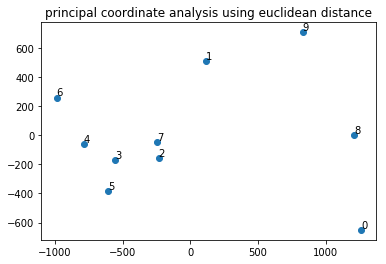

In [44]:
plot_distances(MDS_points.T, 'principal coordinate analysis using euclidean distance')

## Part C

In [27]:
def E_A_B(images_A, images_B):
    recon_A = reconstruct_low_dimentsion_images(images_B, images_A)
    recon_B = reconstruct_low_dimentsion_images(images_A, images_B)
    dists_A = np.array(get_dists(recon_A, images_A))
    dists_B = np.array(get_dists(recon_B, images_B))
    return (dists_A.mean() + dists_B.mean())/2

In [29]:
def get_similarity_metric_matrix(df):
    matrix = np.zeros((10, 10))
    images_by_labels = df.groupby(['label'])
    for i in tqdm_notebook(range(10), desc='1st loop'):
        for j in tqdm_notebook(range(10), desc='2nd loop'):
            class_A = np.array(images_by_labels.get_group(i).drop(['label'], axis=1))
            class_B = np.array(images_by_labels.get_group(j).drop(['label'], axis=1))
            matrix[i][j] = E_A_B(class_A, class_B)
            if(i == j):
                assert matrix[i][j] != 0
    return matrix

In [30]:
similarity_matix = get_similarity_metric_matrix(df)
# similarity_matix

In [31]:
pd.DataFrame(similarity_matix).to_csv('reports/hw4/partc_distances.csv',encoding='utf-8', index=False,header=False, line_terminator='\n')

In [45]:
similarity_dist_points = get_MDS_points(similarity_matix)
similarity_dist_points

array([[ -94.15080549,  368.60936878],
       [-450.48226115, -165.68966534],
       [ 219.36518753,   56.95558961],
       [ 199.71348495, -192.26989326],
       [  85.04082376,  180.21040575],
       [ 326.45455488, -169.5176017 ],
       [ 146.18705937,  -56.10558463],
       [ 154.88041013,   46.4281318 ],
       [-279.47953328,  206.95358762],
       [-307.5289207 , -275.57433863]])

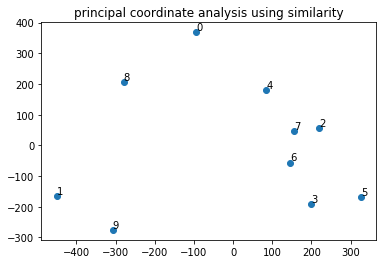

In [46]:
plot_distances(similarity_dist_points.T, 'principal coordinate analysis using similarity')